In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"./Aleppo2017_processed.csv",encoding='utf-8')
print(df.head())

    id                 time     gl
0  183  2015-05-16 05:35:41  162.0
1  183  2015-05-16 05:30:41  164.0
2  183  2015-05-16 05:25:41  168.0
3  183  2015-05-16 05:20:41  169.0
4  183  2015-05-16 05:15:41  170.0


In [4]:
ID = df['id'].value_counts().index
print(ID)

Index([263,  77, 193, 277, 229, 245, 155, 251, 111, 164,
       ...
       128, 264, 186, 162, 249,  39,  52, 266, 223, 289],
      dtype='int64', name='id', length=226)


In [5]:
all_data = []
for i in ID[:20]:
    data = df[df['id']==i]
    data = data.sort_values(by='time')   
    data['target'] = data['gl'].shift(-1)
    
    # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data.dropna()                     
    data = data[['gl','target']].astype(np.float32)  # 修改数据类型
    data = data.iloc[:5000].gl.values
    all_data.append(data)
    break

In [6]:
import numpy as np
all_data = np.array(all_data)
print(all_data.shape)
# 将2000条数据的最后24条用作测试集
test_data_size = 24
train_data = all_data[:,:-test_data_size]
test_data = all_data[:,-test_data_size:]

(1, 5000)


In [7]:
train_data.shape

(1, 4976)

In [8]:
test_data.shape

(1, 24)

### 数据归一化仅应用于训练数据，而不应用于测试数据。如果对测试数据进行归一化，则有可能会将某些信息从训练集泄漏到测试集中。

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.7573771 ]
 [-0.77049184]
 [-0.79016393]
 [-0.79672134]
 [-0.8032787 ]]
[[-0.14754105]
 [-0.15409839]
 [-0.14754105]
 [-0.13442624]
 [-0.12786889]]


In [12]:
import torch
import torch.nn as nn
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [13]:
train_data_normalized.shape

torch.Size([4976])

In [16]:
train_window = 24
def create_inout_sequences(input_data, tw):
    L = len(input_data)
    inout_seq = []
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [17]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [18]:
train_inout_seq[:3]

[(tensor([-0.7574, -0.7705, -0.7902, -0.7967, -0.8033, -0.8098, -0.8098, -0.8098,
          -0.8098, -0.8033, -0.7967, -0.8033, -0.8098, -0.8164, -0.8098, -0.8098,
          -0.8098, -0.8098, -0.8098, -0.8164, -0.8230, -0.8295, -0.8230, -0.8230]),
  tensor([-0.8230])),
 (tensor([-0.7705, -0.7902, -0.7967, -0.8033, -0.8098, -0.8098, -0.8098, -0.8098,
          -0.8033, -0.7967, -0.8033, -0.8098, -0.8164, -0.8098, -0.8098, -0.8098,
          -0.8098, -0.8098, -0.8164, -0.8230, -0.8295, -0.8230, -0.8230, -0.8230]),
  tensor([-0.8164])),
 (tensor([-0.7902, -0.7967, -0.8033, -0.8098, -0.8098, -0.8098, -0.8098, -0.8033,
          -0.7967, -0.8033, -0.8098, -0.8164, -0.8098, -0.8098, -0.8098, -0.8098,
          -0.8098, -0.8164, -0.8230, -0.8295, -0.8230, -0.8230, -0.8230, -0.8164]),
  tensor([-0.8164]))]

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=64, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [20]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.add_module('linear',nn.Linear(64,1))

In [21]:
print(model)

LSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [22]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000108
epoch:  26 loss: 0.00008426
epoch:  51 loss: 0.00009119
epoch:  76 loss: 0.00000777
epoch: 101 loss: 0.00020157
epoch: 126 loss: 0.00000868
epoch: 149 loss: 0.0000130228


In [135]:
fut_pred = 24
test_inputs = train_data_normalized[-train_window:].tolist()
print(len(test_inputs))

20


In [134]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

TypeError: list indices must be integers or slices, not tuple

In [49]:
test_inputs[fut_pred:]

[0.04151177406311035,
 -0.0161171555519104,
 -0.010789990425109863,
 0.022889263927936554,
 0.022737331688404083,
 -0.07471539080142975,
 -0.22732916474342346,
 -0.32408708333969116,
 -0.39435720443725586,
 -0.45700332522392273,
 -0.5201117992401123,
 -0.5593910217285156,
 -0.5689738988876343,
 -0.5285818576812744,
 -0.5237463712692261,
 -0.529400110244751,
 -0.5158089399337769,
 -0.49369436502456665,
 -0.46361038088798523,
 -0.43943145871162415,
 -0.4056631028652191,
 -0.3723333775997162,
 -0.34858426451683044,
 -0.32226309180259705,
 -0.2795800566673279,
 -0.25713270902633667,
 -0.2522478699684143,
 -0.2883049249649048,
 -0.3269151747226715,
 -0.3546961545944214,
 -0.3834458589553833,
 -0.41147956252098083,
 -0.44603875279426575,
 -0.4782434105873108,
 -0.508969783782959,
 -0.5376996994018555,
 -0.5639424324035645,
 -0.5890454053878784,
 -0.6146222352981567,
 -0.6409561634063721,
 -0.6661758422851562,
 -0.6869421005249023,
 -0.6982179880142212,
 -0.6961150169372559,
 -0.6832199096679

In [71]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[148.67385485]
 [146.34648471]
 [142.23606071]
 [137.0501813 ]
 [130.71387884]
 [125.14894929]
 [124.14484362]
 [140.33720278]
 [140.83856069]
 [144.1989053 ]
 [148.40614214]
 [156.68075973]
 [161.28069069]
 [163.99206566]
 [166.71374257]
 [189.72554272]
 [202.62373216]
 [203.03658987]
 [198.39672163]
 [191.07747439]
 [187.39417805]
 [177.89066332]
 [170.07236843]
 [169.48540144]]


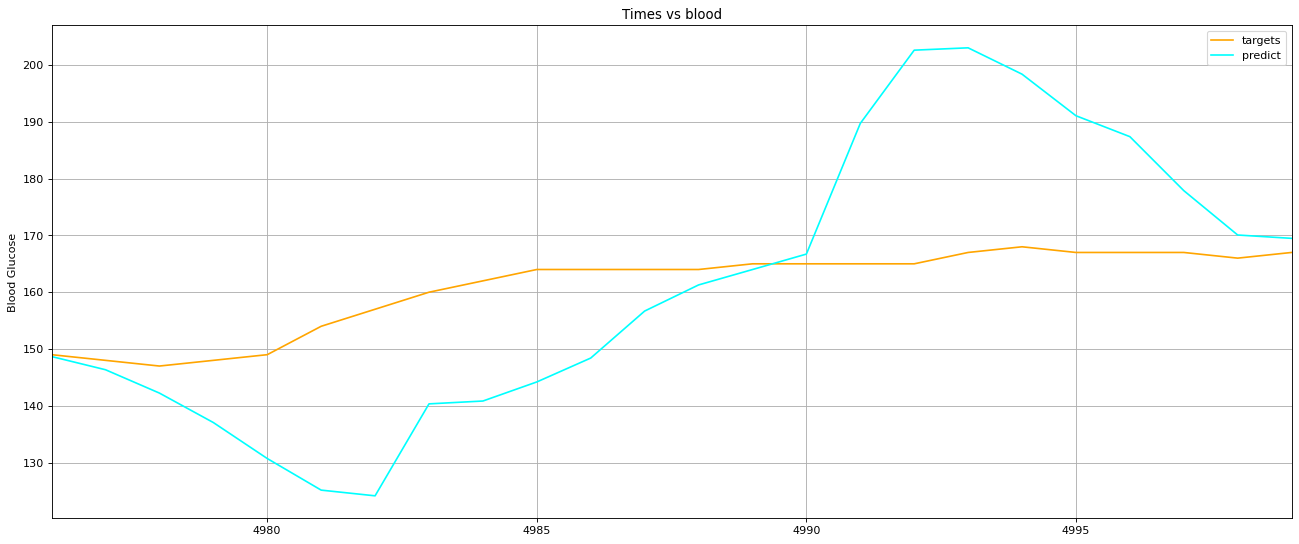

In [76]:
x = np.arange(4976,5000,1)
# print(x)
from matplotlib import pyplot as plt
plt.figure(figsize=(20,8),dpi=80)

plt.title('Times vs blood')
plt.ylabel('Blood Glucose')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
all_data = np.array(all_data).reshape(5000)
plt.plot(x,all_data[-24:], label='targets',color='orange')
plt.plot(x,actual_predictions, label='predict',color='cyan')
plt.legend()
plt.show()

In [78]:
import numpy as np
import pandas as pd

# 示例数据
x = np.array(all_data[-24:])
y = np.array(actual_predictions)

# 使用NumPy计算Pearson相关系数
pearson_corr = np.corrcoef(x.flatten(), y.flatten())[0, 1]
print("Pearson correlation:", pearson_corr)


Pearson correlation: 0.7066781769701418


In [69]:
import pandas as pd

# 创建一个示例的 Series
data = pd.Series([10, 20, 30, 40, 50], index=['a', 'b', 'c', 'd', 'e'])
data

a    10
b    20
c    30
d    40
e    50
dtype: int64

In [73]:
data[2:5]

c    30
d    40
e    50
dtype: int64

In [131]:
x = torch.tensor([[1,2,3],[4,5,6]])
x

tensor([[1, 2, 3],
        [4, 5, 6]])